In [237]:
import numpy as np
import pandas as pd
import quadprog
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, Markdown, Latex

In [3]:
# def solve_qp(double[:, :] G, double[:] a, double[:, :] C=None, double[:] b=None, int meq=0, factorized=False):
"""Solve a strictly convex quadratic program
Minimize     1/2 x^T G x - a^T x
Subject to   C.T x >= b
This routine uses the the Goldfarb/Idnani dual algorithm [1].
References
---------
... [1] D. Goldfarb and A. Idnani (1983). A numerically stable dual
    method for solving strictly convex quadratic programs.
    Mathematical Programming, 27, 1-33.
Parameters
----------
G : array, shape=(n, n)
    matrix appearing in the quadratic function to be minimized
a : array, shape=(n,)
    vector appearing in the quadratic function to be minimized
C : array, shape=(n, m)
    matrix defining the constraints under which we want to minimize the
    quadratic function
b : array, shape=(m), default=None
    vector defining the constraints
meq : int, default=0
    the first meq constraints are treated as equality constraints,
    all further as inequality constraints (defaults to 0).
factorized : bool, default=False
    If True, then we are passing :math:`R^{−1}` (where :math:`G = R^T R`)
    instead of the matrix G in the argument G.
Returns
-------
x : array, shape=(n,)
    vector containing the solution of the quadratic programming problem.
f : float
    the value of the quadratic function at the solution.
xu : array, shape=(n,)
    vector containing the unconstrained minimizer of the quadratic function
iterations : tuple
    2-tuple. the first component contains the number of iterations the
    algorithm needed, the second indicates how often constraints became
    inactive after becoming active first.
lagrangian : array, shape=(m,)
    vector with the Lagragian at the solution.
iact : array
    vector with the indices of the active constraints at the solution.
""";

In [295]:
def f1(*args, **kargs):
    return sklearn.metrics.f1_score(*args, zero_division=0, **kargs)
def linearKern(x, y):
    return float(x.transpose() @ y)
def polyKern(p):
    def poly(x, y): return linearKern(x, y) ** p
    return poly
def gaussKern(b):
    def gauss(x, y): return np.exp(-b * np.sum((x - y) ** 2))
    return gauss
class AnyEstimator(BaseEstimator):
    def __init__(self, params):
        self.params = params
    def fit(self, x, y):
        self.x = x
        self.y = y
        n = len(x)
        self.n = n
        ym = y.reshape(n, 1)
        kern = self.params['kern']
        Cpar = self.params['C']
        a = np.ones(n)
        G = np.array([[y[i] * y[j] * kern(x[i, :], x[j, :]) for j in range(n)] for i in range(n)])
        G = G.reshape((n,n))
        G += np.diag(np.ones(n) * 1e-6)
        assert (G == G.transpose()).all()
        meq = 1
        C = np.concatenate((ym.transpose(), np.identity(n), -np.identity(n)), 0).transpose()
        b = np.append([0], [np.zeros(n), -np.ones(n) * Cpar])
        self.model = quadprog.solve_qp(G, a, C, b, meq)
        lmb = self.model[0]
        lmb_y = lmb * y
        self.lmb = lmb
        self.lmb_y = lmb_y
        iB = None
        for i in range(n):
            if lmb[i] > 0 and lmb[i] < 1 / Cpar:
                iB = i
                break
        if iB is None:
            # raise Exception("oops")
            self.b = 0
            return
        self.b = np.sum([float(lmb_y[j] * kern(x[iB, :], x[j, :])) for j in range(n)]) - y[iB]
    def predict1(self, xs):
        x = self.x
        lmb_y = self.lmb_y
        n = self.n
        kern = self.params['kern']
        b = self.b
        res = []
        for i in range(xs.shape[0]):
            z = xs[i, :]
            res.append(np.sum([lmb_y[i] * kern(x[i, :], z) for i in range(n)]) - b)
        return np.array(res)
    def predict(self, xs):
        res = self.predict1(xs)
        res = np.sign(res)
        res[res == 0] = 1
        return res
    def get_parameters(self):
        return self.params
    def set_parameters(self, params):
        self.params = params
def doJob(df):
    display(df.head(5))
    classes = list(set(df['class']))
    print('classes\t', classes)
    assert len(classes) == 2
    x = np.array(df[['x', 'y']])
    n = len(x)
    y = df['class'].apply(lambda x: -1 if x == classes[0] else 1)
    y = np.array(y)
    print('yshape', y.shape)
    print('n\t', n)
    def testFor(pars):
        print('=========', pars[0]['kern'].__name__)
        Cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
        baccuracy = None
        res = None
        for par in [ {'C': C, **par} for C in Cs for par in pars]:
            est = AnyEstimator(par)
            accuracy = np.mean(cross_val_score(est, x, y, scoring=sklearn.metrics.make_scorer(f1), n_jobs=-1, cv=10))
            if baccuracy is None or accuracy > baccuracy:
                print(accuracy, par)
                baccuracy = accuracy
                res = par
        return (baccuracy, res)
    lin = testFor([{'kern': linearKern}])
    poly = testFor([{'kern': polyKern(p), 'p': p} for p in [2, 3, 4, 5]])
    gauss = testFor([{'kern': gaussKern(beta), 'beta': beta} for beta in [1, 2, 3, 4, 5]])
    def plotK(f, a):
        kern = a[1]['kern']
        est = AnyEstimator(a[1])
        est.fit(x, y)
        display(Markdown('### ' + kern.__name__))
        t = {**a[1]}
        del t['kern']
        print(t)
        mi = np.min(x)
        ma = np.max(x)
        d = ma - mi
        xy = np.arange(mi - d / 10, ma + d / 9.99, d / 100)
        z = np.array([[float(f(est, np.array([x, y]).reshape(1,2))) for x in xy] for y in xy])
        z = z / np.max(np.abs(z))
        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xy, xy, z)
        plt.scatter(x[:, 0], x[:, 1], c=y, s=15, edgecolor='black', linewidth=1)
        plt.show()
    def plotAll(f):
        plotK(f, lin)
        plotK(f, poly)
        plotK(f, gauss)
    display(Markdown('## float'))
    plotAll(lambda e, x: e.predict1(x))
    display(Markdown('## sign'))
    plotAll(lambda e, x: e.predict(x))

# Chips

,x,y,class
0,0.051267,0.69956,P
1,-0.092742,0.68494,P
2,-0.213710,0.69225,P
3,-0.375000,0.50219,P
4,-0.513250,0.46564,P


classes	 ['P', 'N']
yshape (118,)
n	 118
========= linearKern
0.0 {'C': 0.05, 'kern': <function linearKern at 0x7fc72ec83250>}
0.12521367521367524 {'C': 5.0, 'kern': <function linearKern at 0x7fc72ec83250>}
========= poly
0.0 {'C': 0.05, 'kern': <function polyKern.<locals>.poly at 0x7fc72e9e6320>, 'p': 2}
0.10993589743589745 {'C': 0.5, 'kern': <function polyKern.<locals>.poly at 0x7fc72e9e6320>, 'p': 2}
0.21728937728937728 {'C': 0.5, 'kern': <function polyKern.<locals>.poly at 0x7fc72e9e5900>, 'p': 4}
0.29769446240034475 {'C': 1.0, 'kern': <function polyKern.<locals>.poly at 0x7fc72e9e6320>, 'p': 2}
0.3258263305322129 {'C': 1.0, 'kern': <function polyKern.<locals>.poly at 0x7fc72e9e5900>, 'p': 4}
0.4686549707602339 {'C': 5.0, 'kern': <function polyKern.<locals>.poly at 0x7fc72e9e6320>, 'p': 2}
========= gauss
0.0 {'C': 0.05, 'kern': <function gaussKern.<locals>.gauss at 0x7fc72e9e5900>, 'beta': 1}
0.1874084249084249 {'C': 0.5, 'kern': <function gaussKern.<locals>.gauss at 0x7fc72e9e590

## float

### linearKern

{'C': 5.0}


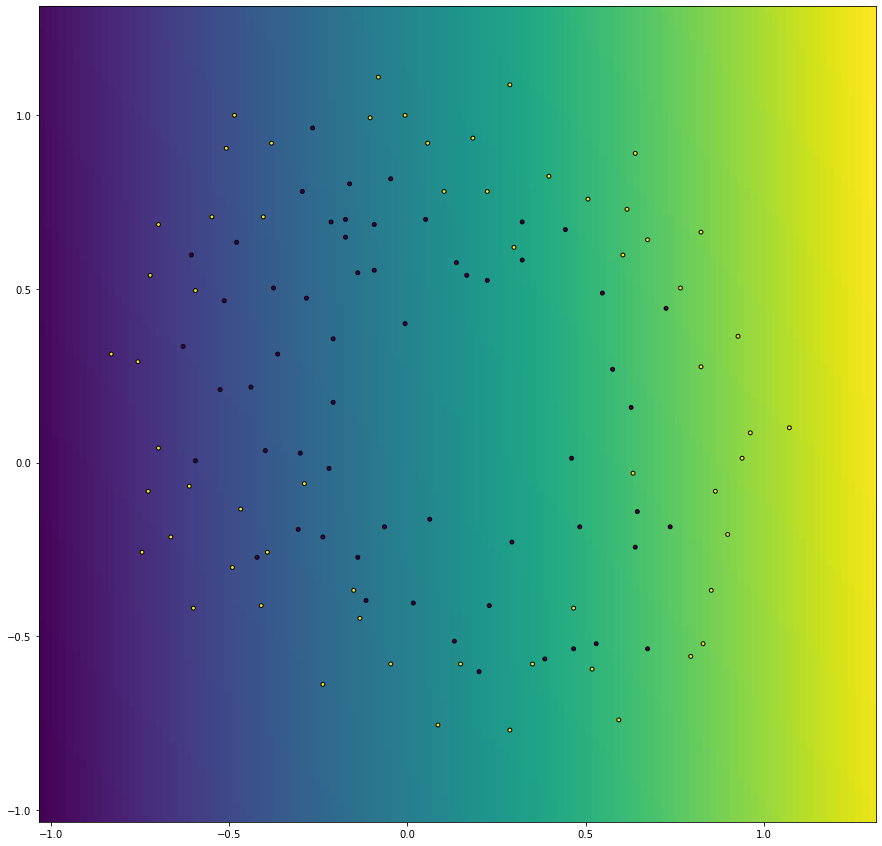

### poly

{'C': 5.0, 'p': 2}


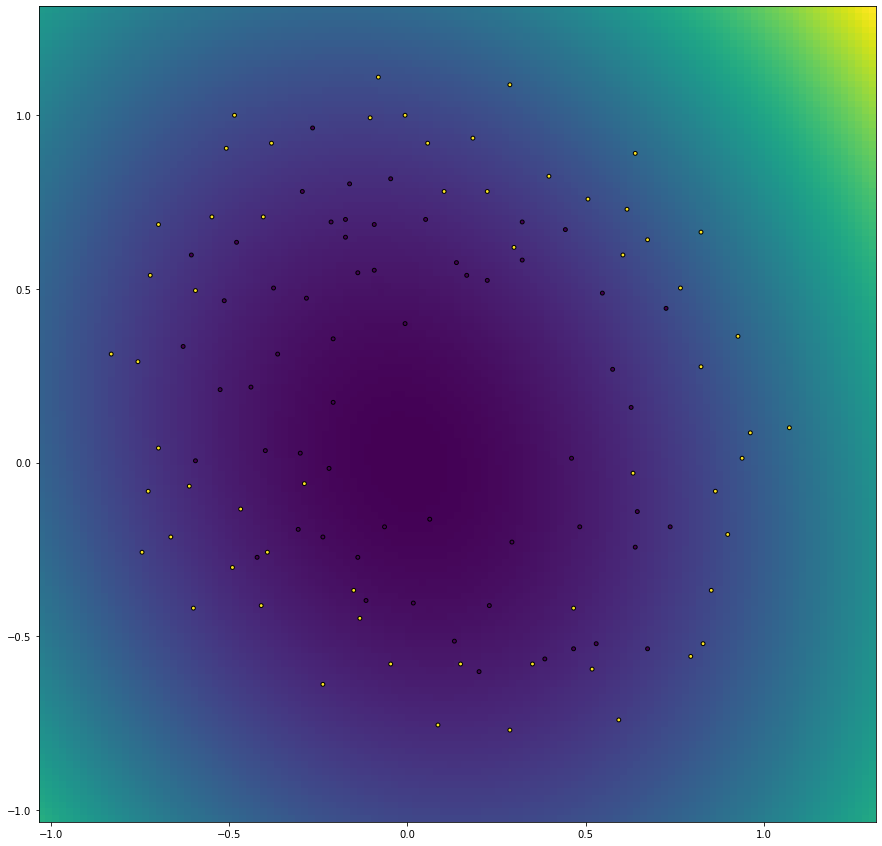

### gauss

{'C': 50.0, 'beta': 1}


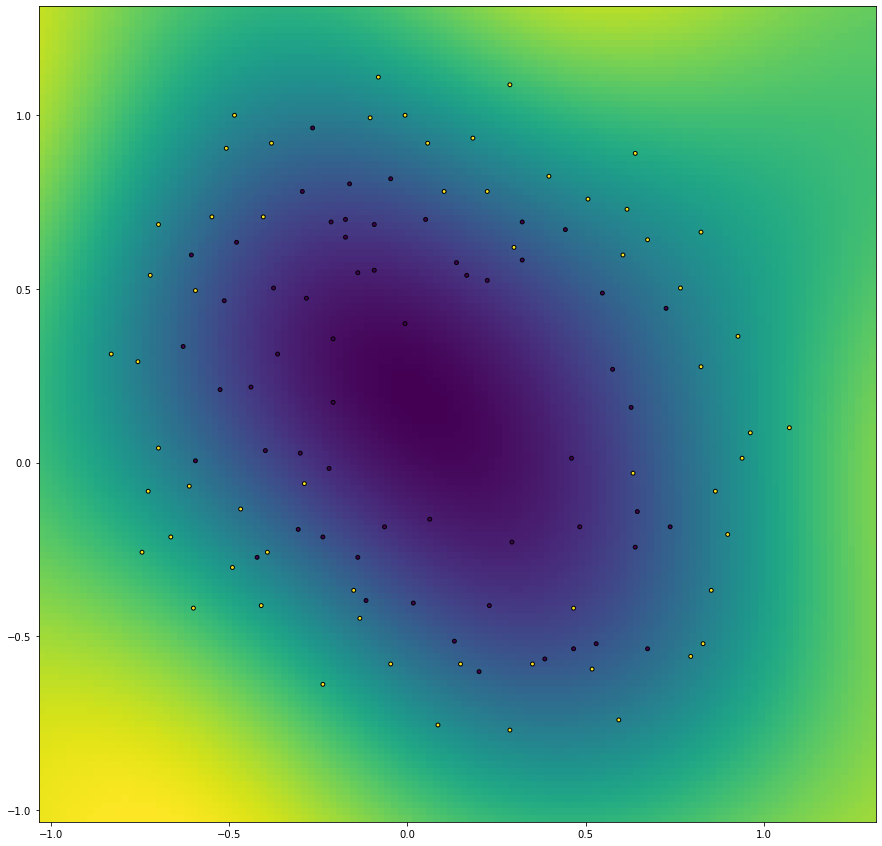

## sign

### linearKern

{'C': 5.0}


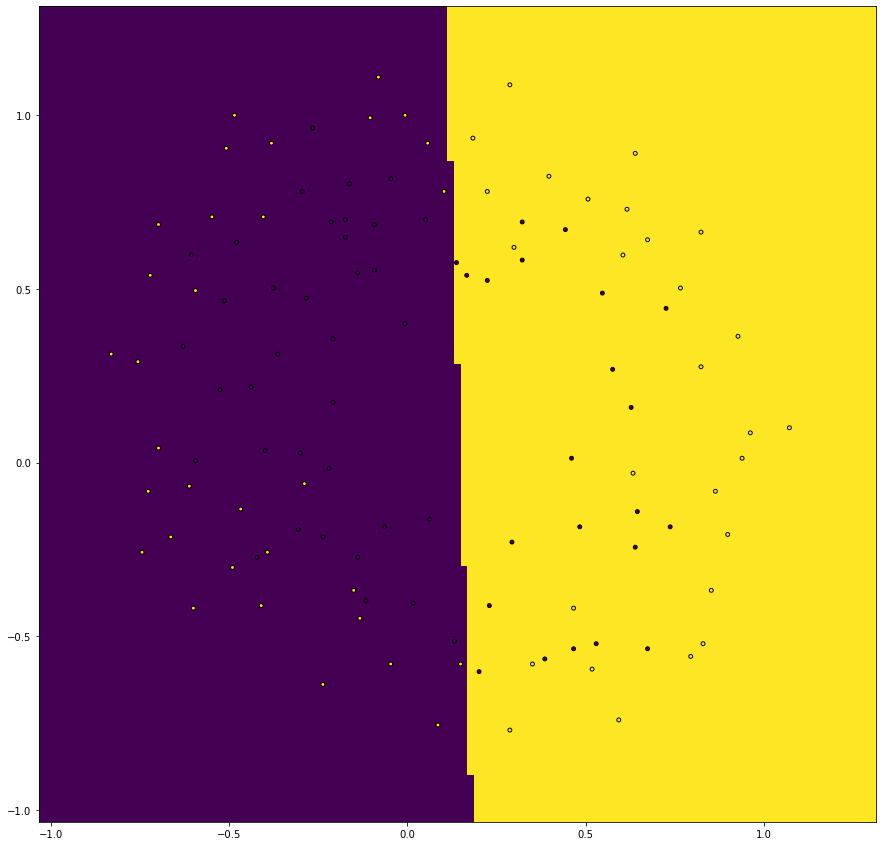

### poly

{'C': 5.0, 'p': 2}


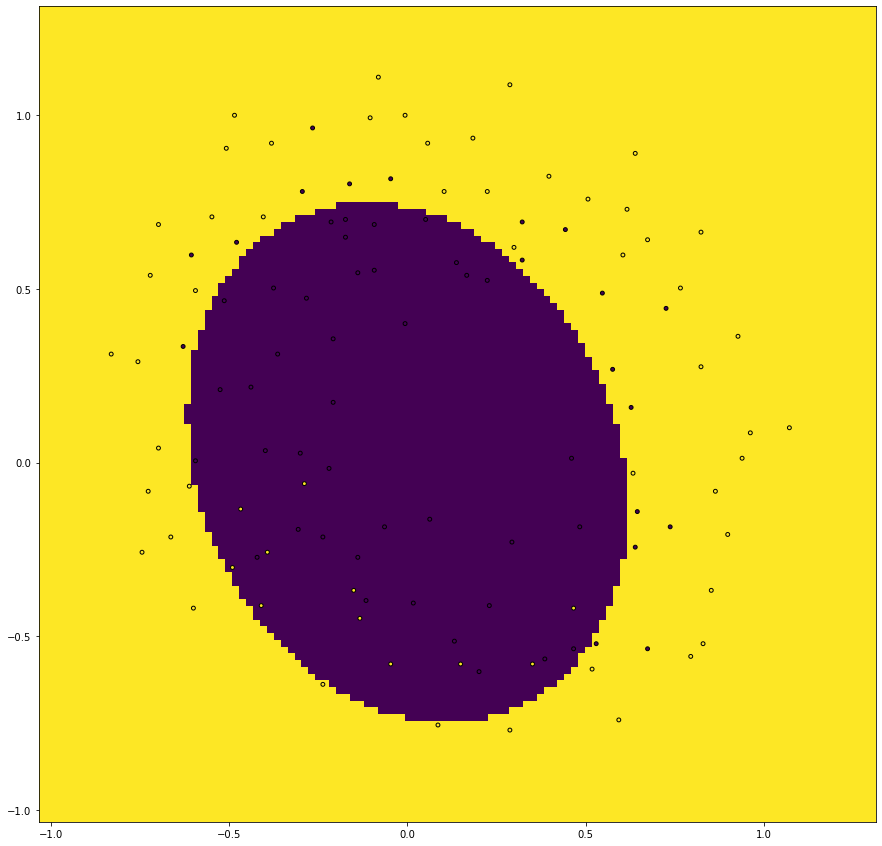

### gauss

{'C': 50.0, 'beta': 1}


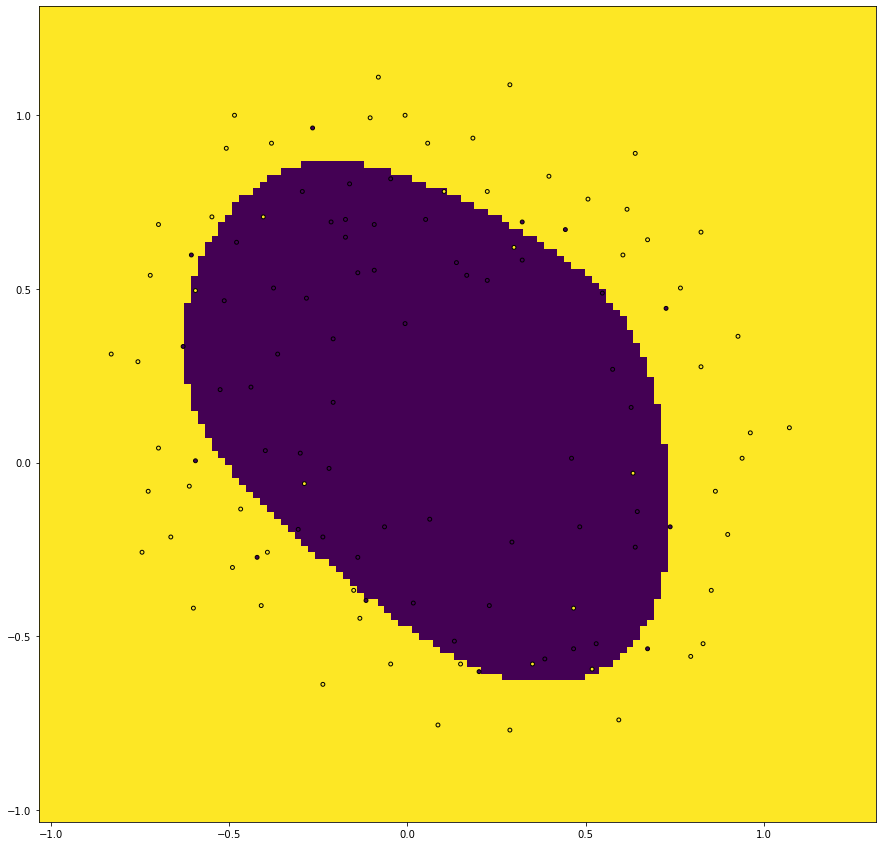

In [293]:
display(Markdown('# Chips'))
doJob(pd.read_csv('./chips.csv'))

# Geyser

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N


classes	 ['P', 'N']
yshape (222,)
n	 222
========= linearKern
0.8134642955610698 {'C': 0.05, 'kern': <function linearKern at 0x7fc72f24d3f0>}
0.8936442147589799 {'C': 0.5, 'kern': <function linearKern at 0x7fc72f24d3f0>}
0.9011616465192903 {'C': 100.0, 'kern': <function linearKern at 0x7fc72f24d3f0>}
========= poly
0.726403200019244 {'C': 0.05, 'kern': <function polyKern.<locals>.poly at 0x7fc72e94cdc0>, 'p': 2}


/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_9719/4045426001.py", line 30, in fit
  File "quadprog/quadprog.pyx", line 105, in quadprog.solve_qp
ValueError: matrix G is not positive definite

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 

0.7303112459962555 {'C': 0.1, 'kern': <function polyKern.<locals>.poly at 0x7fc72e94cdc0>, 'p': 2}
0.7808734345573901 {'C': 1.0, 'kern': <function polyKern.<locals>.poly at 0x7fc72e94cdc0>, 'p': 2}
0.8109107110064313 {'C': 10.0, 'kern': <function polyKern.<locals>.poly at 0x7fc72e94cdc0>, 'p': 2}
========= gauss
0.6751596266766546 {'C': 0.05, 'kern': <function gaussKern.<locals>.gauss at 0x7fc72e94cd30>, 'beta': 1}
0.6772986641098097 {'C': 0.1, 'kern': <function gaussKern.<locals>.gauss at 0x7fc72e94cd30>, 'beta': 1}
0.9100080251289928 {'C': 0.5, 'kern': <function gaussKern.<locals>.gauss at 0x7fc72e94cd30>, 'beta': 1}


## float

### linearKern

{'C': 100.0}


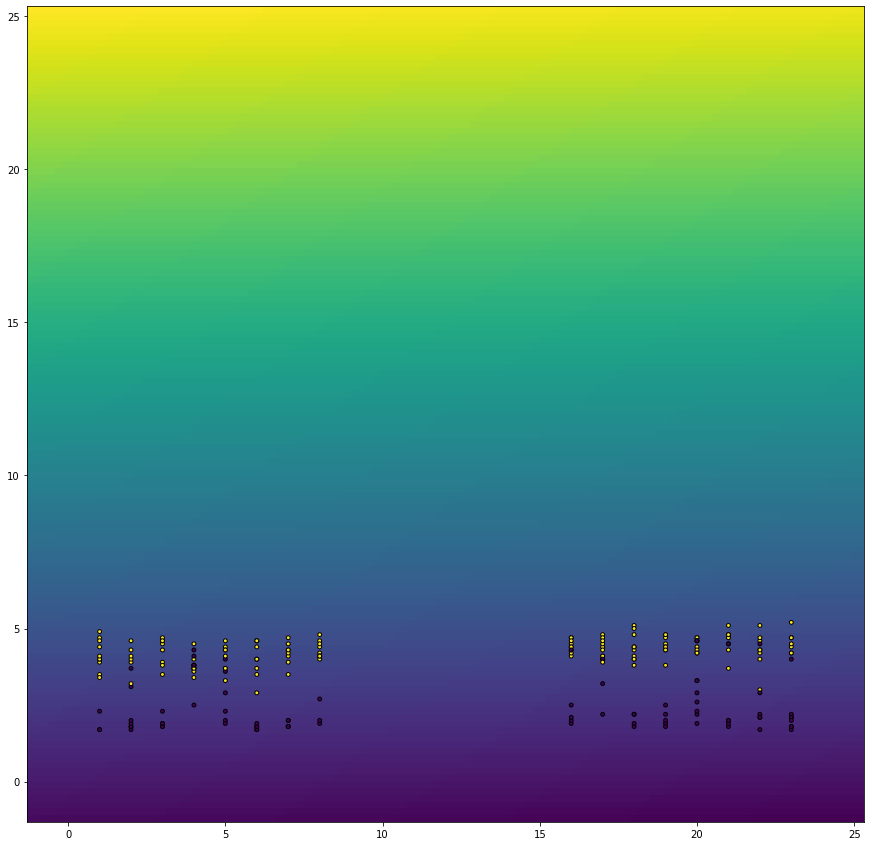

### poly

{'C': 10.0, 'p': 2}


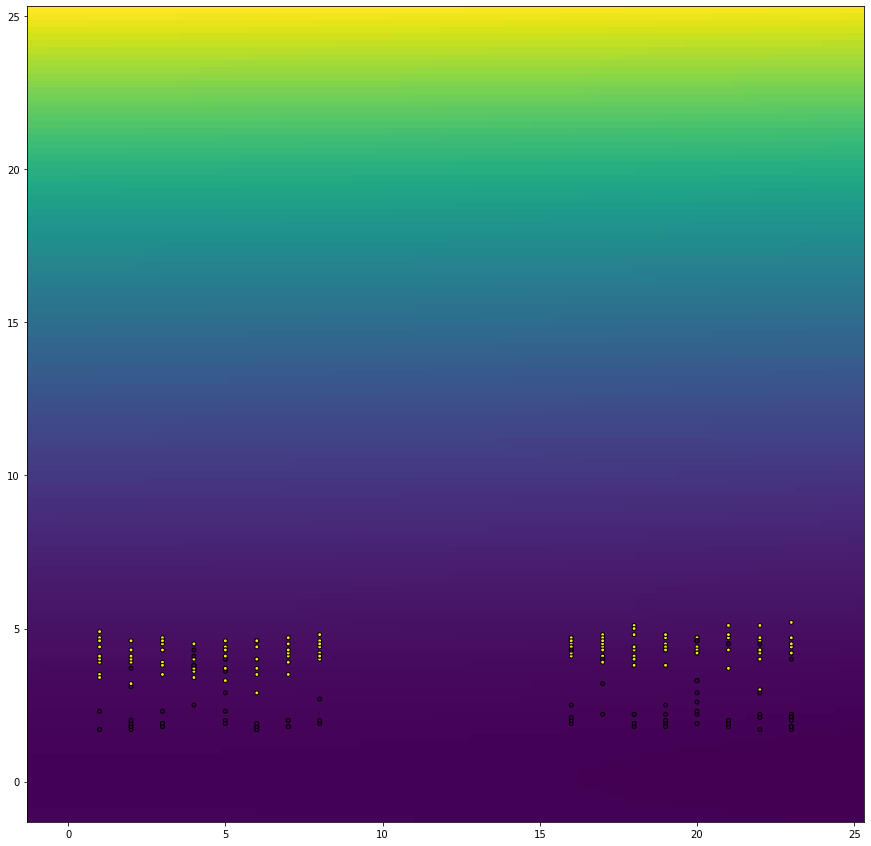

### gauss

{'C': 0.5, 'beta': 1}


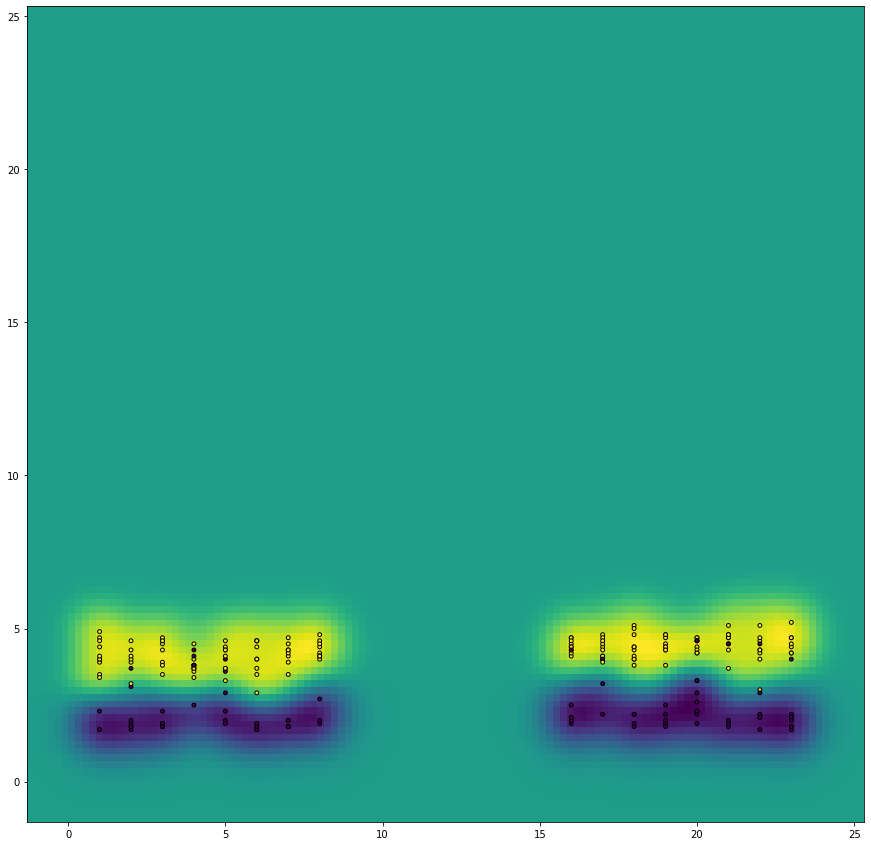

## sign

### linearKern

{'C': 100.0}


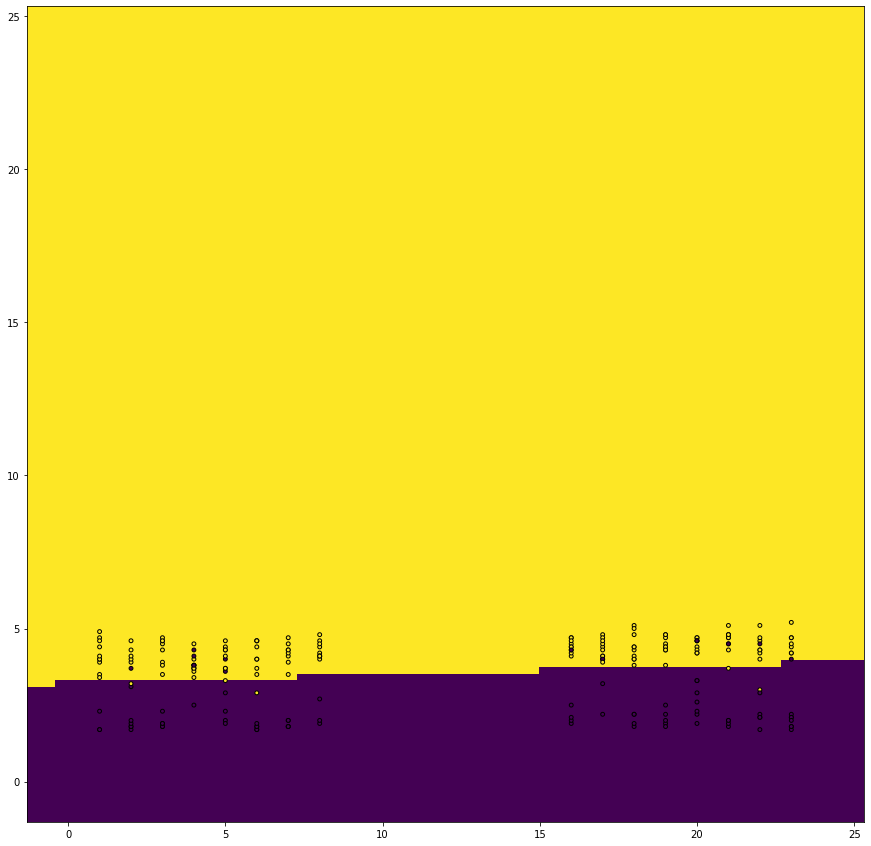

### poly

{'C': 10.0, 'p': 2}


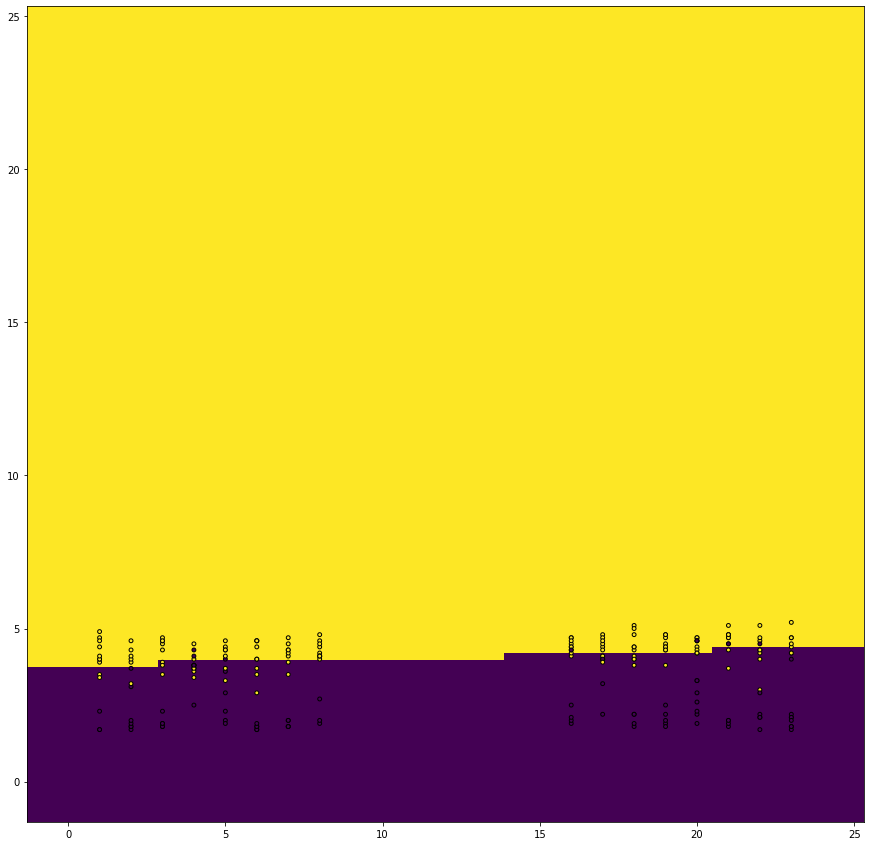

### gauss

{'C': 0.5, 'beta': 1}


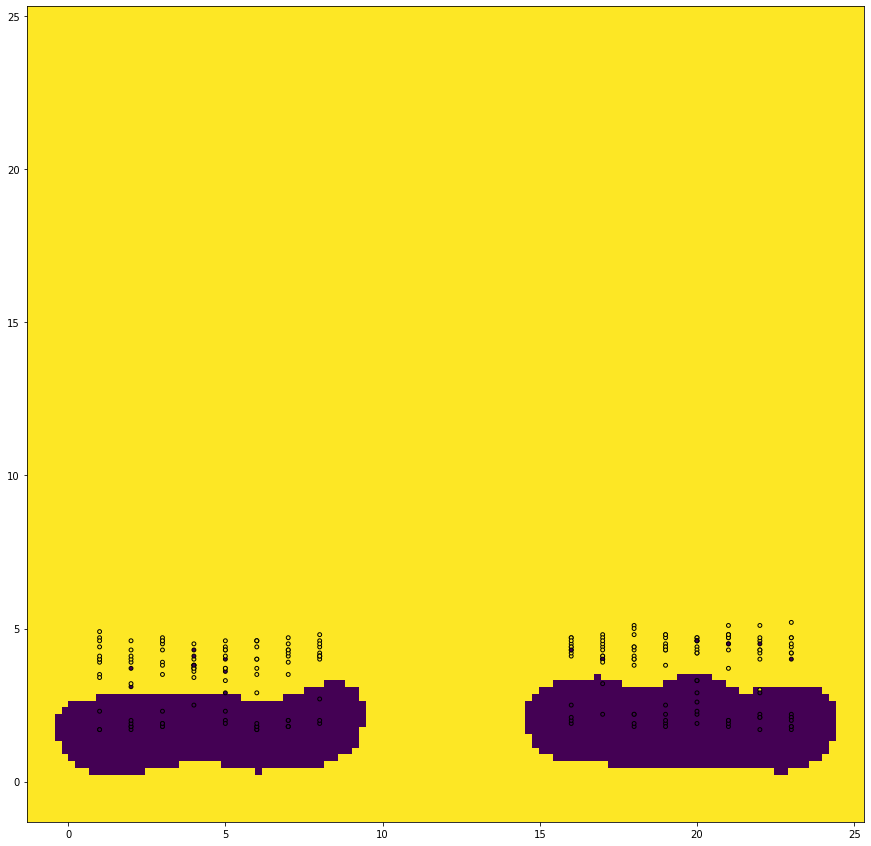

In [296]:
display(Markdown('# Geyser'))
doJob(pd.read_csv('./geyser.csv'))